# Выявление токсичных комментариев

На основе базы комментариев с отметками о токсичности обучить модель для классификации комментариев на позитивные и негативные. Добиться метрики качества F1 не меньше 0.75.

## Подготовка

### Загрузка и анализ данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from pymystem3 import Mystem
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
import collections
sns.set(style = 'darkgrid', palette = 'Set2')

import warnings
warnings.filterwarnings('ignore')

In [2]:
toxic_comments = pd.read_csv('/datasets/toxic_comments.csv')
display(toxic_comments.info())
toxic_comments.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


В датасете 159571 строк и 2 столбца. Пропущенных значений нет

In [3]:
display(toxic_comments['toxic'].value_counts())
ratio = toxic_comments['toxic'].value_counts()[0] / toxic_comments['toxic'].value_counts()[1]
ratio

0    143346
1     16225
Name: toxic, dtype: int64

8.834884437596301

Текст необходимо очистить и лемматизировать.
Почти 90% данных из набора принадлежат к одному классу. Это может очень сильно сместить результаты, и поэтому для классов нужно найти способ балансировки.

### Подготовка признаков

Приведем текст к леммам и очистим

In [4]:
m = Mystem()
def lemmatize(text):
    text = text.lower()
    lemm_text = "".join(m.lemmatize(text))
    clear_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text)
    return " ".join(clear_text.split())

toxic_comments['lemm_text'] = toxic_comments['text'].apply(lemmatize)

toxic_comments = toxic_comments.drop(['text'], axis=1)

In [5]:
features = toxic_comments.drop(['toxic'], axis=1)
target = toxic_comments['toxic']

In [6]:
features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.3, 
                                                                              random_state=12345678)

In [7]:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5,
                                                                            random_state=12345678)

In [8]:
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)


features_train = count_tf_idf.fit_transform(features_train['lemm_text'])
features_valid = count_tf_idf.transform(features_valid['lemm_text'])
features_test = count_tf_idf.transform(features_test['lemm_text'])
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
cv_counts = 4

(111699, 138181)
(23936, 138181)
(23936, 138181)


In [9]:
%%time

classificator = LogisticRegression()
train_f1 = cross_val_score(classificator, 
                      features_train, 
                      target_train,
                      cv=cv_counts, 
                      scoring='f1').mean()
print('F1 на CV', train_f1)

F1 на CV 0.700387428532522
CPU times: user 18.9 s, sys: 17.2 s, total: 36.1 s
Wall time: 36.1 s


Воспользуемся изменением весов классов.

In [10]:
dict_classes={0:1, 1:ratio}

In [11]:
%%time

classificator = LogisticRegression(class_weight=dict_classes)
f1_train_ballanced = cross_val_score(classificator, 
                                    features_train, 
                                    target_train, 
                                    cv=cv_counts, 
                                    scoring='f1').mean()
print('F1 с балансированными классами (CV)', f1_train_ballanced)

F1 с балансированными классами (CV) 0.7565948395022247
CPU times: user 32.9 s, sys: 29.7 s, total: 1min 2s
Wall time: 1min 2s


В поцессе предобработки были получены признаки и разделена выборка. Для балансирования используем метод, учитывающий вес классов.

## Обучение

Попробуем разные модели: логистическую регрессию, стохастический градиентный спуск и несколько деревьев.

LogisticRegression

In [12]:
%%time

regressor = LogisticRegression()
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':[dict_classes]}]


print('_____Tuning hyper-parameters for f1_score_____')
print()

clf = GridSearchCV(regressor, hyperparams, scoring='f1', cv=cv_counts)
clf.fit(features_train, target_train)
LR_best_params = clf.best_params_
print("Best parameters set:", LR_best_params)
print()

print("Grid scores (development set):")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

LR_cv_f1 = max(means)

_____Tuning hyper-parameters for f1_score_____

Best parameters set: {'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'lbfgs'}

Grid scores (development set):

0.720867 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'newton-cg'}
0.720916 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'lbfgs'}
0.721014 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'liblinear'}
0.756595 for {'C': 1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'newton-cg'}
0.756346 for {'C': 1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'lbfgs'}
0.756595 for {'C': 1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'liblinear'}
0.764817 for {'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'newton-cg'}
0.764973 for {'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'lbfgs'}
0.764817 for {'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'liblinear'}

CPU ti

In [13]:
%%time

regressor = LogisticRegression()
regressor.set_params(**clf.best_params_)
regressor.fit(features_train, target_train)
target_predict = regressor.predict(features_valid)
LR_valid_f1 = f1_score(target_valid, target_predict)
print('F1 на cv', LR_cv_f1)
print('F1 на валидации', LR_valid_f1)

F1 на cv 0.7649734527409647
F1 на валидации 0.7653981953707335
CPU times: user 25.8 s, sys: 27.4 s, total: 53.3 s
Wall time: 53.3 s


SGDClassifier

In [14]:
%%time

classifier = SGDClassifier()
hyperparams = [{'loss':['hinge', 'log', 'modified_huber'],
                'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
                'eta0':[0.01, 0.05, 0.1],
                'random_state':[1234567],
                'class_weight':[dict_classes]}]


print('_____Tuning hyper-parameters for f1_score_____')
print()

clf = GridSearchCV(classifier, hyperparams, scoring='f1', cv=cv_counts)
clf.fit(features_train, target_train)
SGDC_best_params = clf.best_params_
print("Best parameters set:", SGDC_best_params)
print()


print("Grid scores (development set):")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

SGDC_cv_f1 = max(means)

_____Tuning hyper-parameters for f1_score_____

Best parameters set: {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'random_state': 1234567}

Grid scores (development set):

0.742088 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'hinge', 'random_state': 1234567}
0.720790 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'log', 'random_state': 1234567}
0.753660 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'modified_huber', 'random_state': 1234567}
0.742659 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'hinge', 'random_state': 1234567}
0.721124 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'log', 'random_state': 1234567}
0.758401 for {'class_weight':

In [15]:
%%time

classifier = SGDClassifier()
classifier.set_params(**clf.best_params_)
classifier.fit(features_train, target_train)
target_predict = classifier.predict(features_valid)
SGDC_valid_f1 = f1_score(target_valid, target_predict)
print('F1 на cv', SGDC_cv_f1)
print('F1 на валидации', SGDC_valid_f1)

F1 на cv 0.7611544465072447
F1 на валидации 0.7546270844786513
CPU times: user 2.63 s, sys: 13.4 ms, total: 2.65 s
Wall time: 2.67 s


DecisionTreeClassifier

In [16]:
%%time

classificator = DecisionTreeClassifier()
hyperparams = [{'max_depth':[x for x in range(30,51,2)],
                'random_state':[12082020],
                'class_weight':[dict_classes]}]

print('_____Tuning hyper-parameters for f1_score_____')
print()

clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
DTC_best_params = clf.best_params_
print("Best parameters set:", DTC_best_params)
print()


print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

DTC_cv_f1 = max(means)

_____Tuning hyper-parameters for f1_score_____

Best parameters set: {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 50, 'random_state': 12082020}

Grid scores on development set:

0.628370 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 30, 'random_state': 12082020}
0.634810 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 32, 'random_state': 12082020}
0.630901 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 34, 'random_state': 12082020}
0.632364 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 36, 'random_state': 12082020}
0.629889 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 38, 'random_state': 12082020}
0.626588 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 40, 'random_state': 12082020}
0.631377 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 42, 'random_state': 12082020}
0.631659 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 44, 'random_s

In [17]:
%%time

classificator = DecisionTreeClassifier()
classificator.set_params(**DTC_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
DTC_valid_f1 = f1_score(target_valid, target_predict)
print('F1 на cv', DTC_cv_f1)
print('F1 на валидации', DTC_valid_f1)

F1 на cv 0.6403632460310067
F1 на валидации 0.6245572609208974
CPU times: user 57.6 s, sys: 0 ns, total: 57.6 s
Wall time: 57.9 s


RandomForestClassifier

In [18]:
%%time

classificator = RandomForestClassifier()э,№5
hyperparams = [{'max_depth':[x for x in+---------------------------------------------------жд range(80, 90, 1)],
                'random_state':[12345678],
                'class_weight':[dict_classes]}]

print('_____Tuning hyper-parameters for f1_score_____')
print()

clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
RFC_best_params = clf.best_params_
print("Best parameters set:", RFC_best_params)
print()


print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

RFC_cv_f1 = max(means)

_____Tuning hyper-parameters for f1_score_____

Best parameters set: {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 89, 'random_state': 12345678}

Grid scores on development set:

0.453184 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 80, 'random_state': 12345678}
0.456576 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 81, 'random_state': 12345678}
0.454380 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 82, 'random_state': 12345678}
0.456632 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 83, 'random_state': 12345678}
0.458175 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 84, 'random_state': 12345678}
0.457418 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 85, 'random_state': 12345678}
0.461625 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 86, 'random_state': 12345678}
0.460655 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 87, 'random_s

In [19]:
%%time

classificator = RandomForestClassifier()
classificator.set_params(**RFC_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
RFC_valid_f1 = f1_score(target_valid, target_predict)
print('F1 на cv', RFC_cv_f1)
print('F1 на валидации', RFC_valid_f1)

F1 на cv 0.4658552481567498
F1 на валидации 0.472944776742245
CPU times: user 12.5 s, sys: 0 ns, total: 12.5 s
Wall time: 12.5 s


Обучено 4 различные модели, но только две из них показали необходимый результат: метрики деревьев оказались ниже, чем необходимо.

## Выводы

                ROC_AUC     LR_F1 LR_Precision LR_Recall LR_Accuracy
SGDClassifier  0.969606  0.756181     0.683162  0.846678    0.946441
                     ROC_AUC     LR_F1 LR_Precision LR_Recall LR_Accuracy
LogisticRegression  0.964936  0.765502     0.728006   0.80707    0.951496


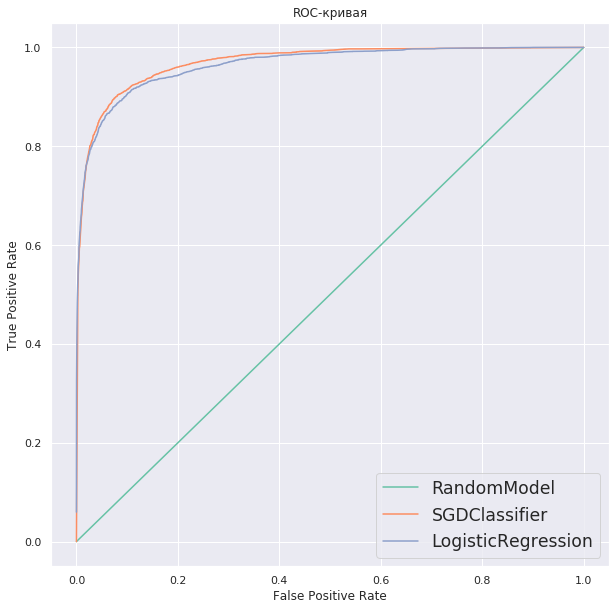

In [22]:
plt.figure(figsize=(10, 10))
sns.lineplot([0, 1], [0, 1], linestyle='--', label='RandomModel')

classificator = SGDClassifier()
classificator.set_params(**SGDC_best_params)
classificator.fit(features_train, target_train)
probabilities_test = classificator.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = classificator.predict(features_test)
sns.lineplot(fpr, tpr, label='SGDClassifier')
LR_ROC_AUC = roc_auc_score(target_test, probabilities_one_test)
LR_F1 = f1_score(target_test, predict_test)
LR_Precision = precision_score(target_test, predict_test)
LR_Recall = recall_score(target_test, predict_test)
LR_Accuracy = accuracy_score(target_test, predict_test)
report_1 = pd.DataFrame(columns = ["ROC_AUC",
                               "LR_F1",
                               "LR_Precision",
                               "LR_Recall",
                               "LR_Accuracy"],
                      index = ["SGDClassifier"])


report_1.iloc[0] = [LR_ROC_AUC, LR_F1, LR_Precision, LR_Recall, LR_Accuracy]
print(report_1)


classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
probabilities_test = classificator.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = classificator.predict(features_test)
sns.lineplot(fpr, tpr, label='LogisticRegression')
SGDC_ROC_AUC = roc_auc_score(target_test, probabilities_one_test)
SGDC_F1 = f1_score(target_test, predict_test)
SGDC_Precision = precision_score(target_test, predict_test)
SGDC_Recall = recall_score(target_test, predict_test)
SGDC_Accuracy = accuracy_score(target_test, predict_test)


report_2 = pd.DataFrame(columns = ["ROC_AUC",
                               "LR_F1",
                               "LR_Precision",
                               "LR_Recall",
                               "LR_Accuracy"],
                      index = ["LogisticRegression"])


report_2.iloc[0] = [SGDC_ROC_AUC, SGDC_F1, SGDC_Precision, SGDC_Recall, SGDC_Accuracy]
print(report_2)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

Данные подготовили.
Данные разделили на выборки и выбрали способ балансировки.
Обучили модели и выбрали две лучшие: SGDClassifier, LogisticRegression.
Рассчитаны параметры качества моделей.
На тестовой выбоке по метрике F1 самой продуктивной оказалась модель LogisticRegression, судя по значениям Precision и Accuracy лучше всего находит необходимые комментарии.

У SGDClassifier значения ROC AUC и Recall выше, чем у LogisticRegression, данная модель может обработать больше запсей.